In [1]:
import nltk
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from math import sqrt
import pandas as pd
import numpy as np
import copy 
import pickle
import os
from pprint import pprint
import math
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\xiao\anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
df_combined=pd.read_csv('host_data_NYC_11_30.csv')
df_combined.drop(['host_verifications','host_has_profile_pic','host_identity_verified'],axis=1,inplace=True)
data_with_cm = copy.deepcopy(df_combined.dropna(axis=0,how='any'))

In [4]:
data_with_cm.columns[data_with_cm.dtypes == 'object']

Index(['neighbourhood_group_cleansed', 'instant_bookable', 'comments',
       'has_availability', 'neighbourhood_cleansed'],
      dtype='object')

In [5]:
data_with_cm.shape

(24912, 30)

In [6]:
data_with_cm = pd.get_dummies(data_with_cm,columns=['neighbourhood_group_cleansed','instant_bookable','has_availability', 'neighbourhood_cleansed'])

In [7]:
data_with_cm.shape

(24912, 252)

In [8]:
import string
#punctuation remover
def remove_punctuation(text):
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)
data_with_cm['comments'] = data_with_cm['comments'].apply(remove_punctuation)

In [9]:
# create an object of stemming function
stemmer = SnowballStemmer("english")

def stemming(text):
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)
data_with_cm['comments'] = data_with_cm['comments'].apply(stemming)

KeyboardInterrupt: 

In [ ]:
data_with_cm = shuffle(data_with_cm)
# Extract features and labels
y = data_with_cm['host_is_superhost']
X = data_with_cm.drop('host_is_superhost', axis = 1)

# Training and Testing Sets
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 996)

train_X, train_y = RandomOverSampler().fit_sample(train_X, train_y)

# train_X = np.array(train_X)
# test_X = np.array(test_X)
# train_y = np.array(train_y)
# test_y = np.array(test_y)

train_X.shape, test_X.shape

In [9]:
train_y.value_counts()

True     14031
False    14031
Name: host_is_superhost, dtype: int64

In [16]:
tuple_objects = ( train_X, test_X, train_y,test_y)
# Save tuple
pickle.dump(tuple_objects, open("train_test_data_for_host.pkl", 'wb'))

In [15]:
def model_predict(model, X_train, X_test,y_train,y_test):
    y_predictions = model.predict(X_test)
    print("Accuracy")
    #train_test_accuracy
    print ("Train Accuracy : {}".format(accuracy_score(y_train, model.predict(X_train))))
    print ("Test Accuracy  : {}".format(accuracy_score(y_test, y_predictions)))
    print("")
    print("Confusion Matrix")
    #confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_predictions).ravel()
    print("True Negative: {}".format(tn))
    print("True Positive: {}".format(tp))
    print("False Negative: {}".format(fn))
    print("False Positive: {}".format(fp))
    print("")
    #classification_report
    print("Classification Report")
    print(classification_report(y_test, y_predictions, target_names=['Not_Superhost', 'Superhost']))
    #roc_curve
    print("")
    plot_roc(y_test, X_test, model=model, model_name="classifier")
    return None

def plot_roc(y_test, X_test, model, model_name):
    try:
        AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='#0AB2A4', lw=lw, label='ROC curve (area = %0.2f)' % AUC)
        plt.plot([0, 1], [0, 1], color='#BA2B14', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC {}'.format(str(model.__class__).split('.')[-1].split("'")[0]))
        plt.legend(loc="lower right");
    except:
        None

## CountVectorizer only for comments

In [11]:
# train_X, test_X, train_y,test_y = pickle.load(open("train_test_data_for_host.pkl", 'rb'))

In [12]:
train_X_cv = copy.deepcopy(train_X)
test_X_cv = copy.deepcopy(test_X)

In [12]:
cv = CountVectorizer(stop_words='english', lowercase=True).fit(train_X_cv['comments'])#创建词袋数据结构
train_X_cv_cm = cv.transform(train_X_cv['comments'])
test_X_cv_cm = cv.transform(test_X_cv['comments'])

In [13]:
train_X_cv.drop(['comments'],axis=1,inplace=True)
test_X_cv.drop(['comments'],axis=1,inplace=True)

#### logistics regression

Accuracy
Train Accuracy : 0.9877770650702017
Test Accuracy  : 0.7724791265253693

Confusion Matrix
True Negative: 4004
True Positive: 807
False Negative: 774
False Positive: 643

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.84      0.86      0.85      4647
    Superhost       0.56      0.51      0.53      1581

     accuracy                           0.77      6228
    macro avg       0.70      0.69      0.69      6228
 weighted avg       0.77      0.77      0.77      6228




c:\users\xiao\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


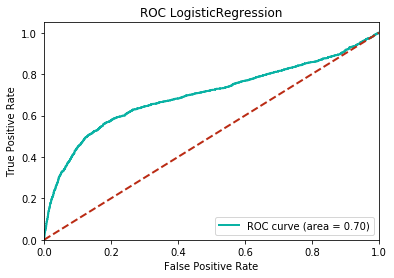

In [13]:
LR1 = LogisticRegression(max_iter=1000)
LR1.fit(train_X_cv_cm, train_y)
model_predict(LR1,train_X_cv_cm,test_X_cv_cm,train_y,test_y)

Accuracy
Train Accuracy : 0.7330553773786616
Test Accuracy  : 0.7140333975594091

Confusion Matrix
True Negative: 3324
True Positive: 1123
False Negative: 458
False Positive: 1323

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.88      0.72      0.79      4647
    Superhost       0.46      0.71      0.56      1581

     accuracy                           0.71      6228
    macro avg       0.67      0.71      0.67      6228
 weighted avg       0.77      0.71      0.73      6228




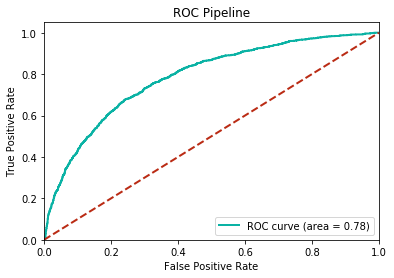

In [28]:
LR2 = make_pipeline(SimpleImputer(), StandardScaler(),LogisticRegression(max_iter=1000))
LR2.fit(train_X_cv, train_y)
model_predict(LR2,train_X_cv,test_X_cv,train_y,test_y)

#### Naive Bayes

Accuracy
Train Accuracy : 0.8433112393984749
Test Accuracy  : 0.6032434168272318

Confusion Matrix
True Negative: 2545
True Positive: 1212
False Negative: 369
False Positive: 2102

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.87      0.55      0.67      4647
    Superhost       0.37      0.77      0.50      1581

     accuracy                           0.60      6228
    macro avg       0.62      0.66      0.58      6228
 weighted avg       0.74      0.60      0.63      6228




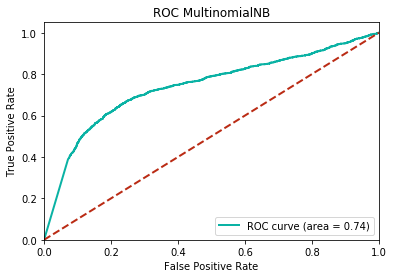

In [21]:
NB1 = MultinomialNB()
NB1.fit(train_X_cv_cm, train_y)
model_predict(NB1,train_X_cv_cm,test_X_cv_cm,train_y,test_y)

Accuracy
Train Accuracy : 0.5702729670016392
Test Accuracy  : 0.3684971098265896

Confusion Matrix
True Negative: 824
True Positive: 1471
False Negative: 110
False Positive: 3823

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.88      0.18      0.30      4647
    Superhost       0.28      0.93      0.43      1581

     accuracy                           0.37      6228
    macro avg       0.58      0.55      0.36      6228
 weighted avg       0.73      0.37      0.33      6228




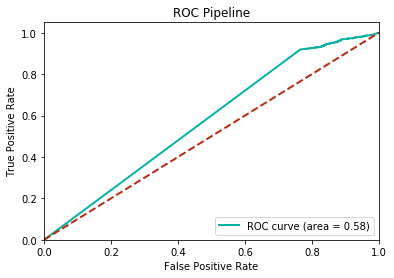

In [30]:
NB2 = make_pipeline(SimpleImputer(), StandardScaler(),GaussianNB())
NB2.fit(train_X_cv, train_y)
model_predict(NB2,train_X_cv,test_X_cv,train_y,test_y)

#### Random Forest

Accuracy
Train Accuracy : 0.9590193143753118
Test Accuracy  : 0.7581888246628131

Confusion Matrix
True Negative: 4004
True Positive: 718
False Negative: 863
False Positive: 643

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.82      0.86      0.84      4647
    Superhost       0.53      0.45      0.49      1581

     accuracy                           0.76      6228
    macro avg       0.68      0.66      0.66      6228
 weighted avg       0.75      0.76      0.75      6228




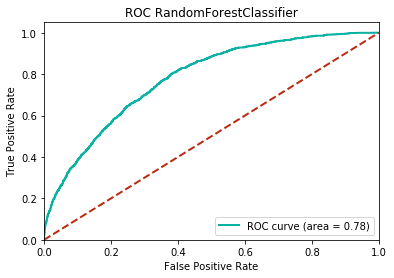

In [34]:
RF1 = RandomForestClassifier(max_depth = 70,n_estimators=1000,n_jobs=-1)
RF1.fit(train_X_cv_cm, train_y)
model_predict(RF1,train_X_cv_cm,test_X_cv_cm,train_y,test_y)

Accuracy
Train Accuracy : 1.0
Test Accuracy  : 0.8493898522800257

Confusion Matrix
True Negative: 4265
True Positive: 1025
False Negative: 556
False Positive: 382

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.88      0.92      0.90      4647
    Superhost       0.73      0.65      0.69      1581

     accuracy                           0.85      6228
    macro avg       0.81      0.78      0.79      6228
 weighted avg       0.85      0.85      0.85      6228




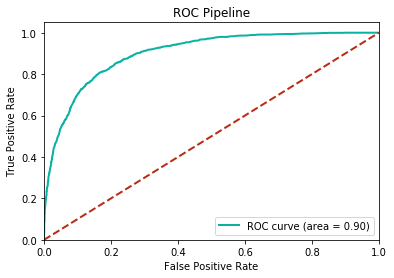

In [35]:
RF2 = make_pipeline(SimpleImputer(), StandardScaler(),RandomForestClassifier(max_depth = 70,n_estimators=1000,n_jobs=-1))
RF2.fit(train_X_cv, train_y)
model_predict(RF2,train_X_cv,test_X_cv,train_y,test_y)

#### xgboost

c:\users\xiao\anaconda3\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:32:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy
Train Accuracy : 0.9992516570451144
Test Accuracy  : 0.7923892100192679

Confusion Matrix
True Negative: 4169
True Positive: 766
False Negative: 815
False Positive: 478

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.84      0.90      0.87      4647
    Superhost       0.62      0.48      0.54      1581

     accuracy                           0.79      6228
    macro avg       0.73      0.69      0.70      6228
 weighted avg       0.78      0.79      0.78      6228




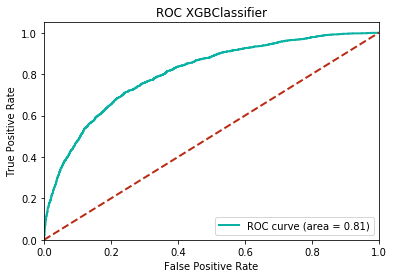

In [24]:
xgb1 = XGBClassifier(learning_rate = 0.2,max_depth=10,n_estimators=1000)
xgb1.fit(train_X_cv_cm, train_y)
model_predict(xgb1,train_X_cv_cm,test_X_cv_cm,train_y,test_y)

c:\users\xiao\anaconda3\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:37:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy
Train Accuracy : 1.0
Test Accuracy  : 0.8493898522800257

Confusion Matrix
True Negative: 4225
True Positive: 1065
False Negative: 516
False Positive: 422

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.89      0.91      0.90      4647
    Superhost       0.72      0.67      0.69      1581

     accuracy                           0.85      6228
    macro avg       0.80      0.79      0.80      6228
 weighted avg       0.85      0.85      0.85      6228




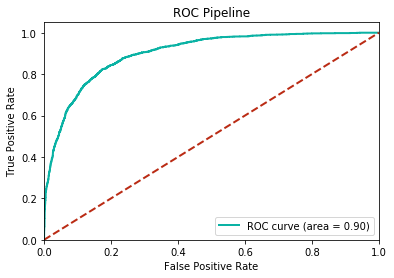

In [16]:
xgb2 = make_pipeline(SimpleImputer(), StandardScaler(),XGBClassifier(learning_rate = 0.2,max_depth=10,n_estimators=1000))
xgb2.fit(train_X_cv, train_y)
model_predict(xgb2,train_X_cv,test_X_cv,train_y,test_y)

In [18]:
importances = xgb2.steps[2][1].feature_importances_
pd.set_option('display.max_rows', None)
feature_importances = pd.DataFrame({"feature":train_X_cv.columns.values, "importance":importances})
feature_importances.sort_values("importance", ascending=False)

,feature,importance
100,neighbourhood_cleansed_Edgemere,0.028575
38,neighbourhood_cleansed_Bath Beach,0.025976
213,neighbourhood_cleansed_South Ozone Park,0.023969
218,neighbourhood_cleansed_St. George,0.021487
106,neighbourhood_cleansed_Financial District,0.020359
77,neighbourhood_cleansed_Columbia St,0.020114
96,neighbourhood_cleansed_East New York,0.019924
194,neighbourhood_cleansed_Red Hook,0.019264
151,neighbourhood_cleansed_Lower East Side,0.019019
207,neighbourhood_cleansed_Sheepshead Bay,0.017050


## TfidfVectorizer only

In [10]:
# train_X, test_X, train_y,test_y = pickle.load(open("train_test_data_for_host.pkl", 'rb'))

In [26]:
train_X_tf = copy.deepcopy(train_X)
test_X_tf = copy.deepcopy(test_X)

In [8]:
tf = TfidfVectorizer(stop_words='english', lowercase=True).fit(train_X_tf['comments'])#创建词袋数据结构
train_X_tf_cm = tf.transform(train_X_tf['comments'])
test_X_tf_cm = tf.transform(test_X_tf['comments'])

### Logis Reg

Accuracy
Train Accuracy : 0.8817261777492694
Test Accuracy  : 0.7410083493898523

Confusion Matrix
True Negative: 3467
True Positive: 1148
False Negative: 433
False Positive: 1180

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.89      0.75      0.81      4647
    Superhost       0.49      0.73      0.59      1581

     accuracy                           0.74      6228
    macro avg       0.69      0.74      0.70      6228
 weighted avg       0.79      0.74      0.75      6228




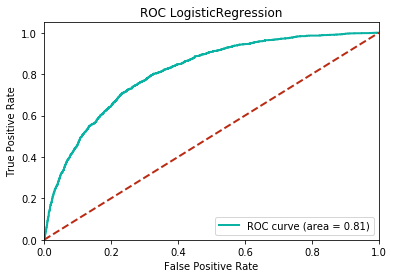

In [9]:
LR1 = LogisticRegression(max_iter=1000)
LR1.fit(train_X_tf_cm, train_y)
model_predict(LR1,train_X_tf_cm,test_X_tf_cm,train_y,test_y)

#### NB

Accuracy
Train Accuracy : 0.6195923312664814
Test Accuracy  : 0.3416827231856134

Confusion Matrix
True Negative: 560
True Positive: 1568
False Negative: 13
False Positive: 4087

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.98      0.12      0.21      4647
    Superhost       0.28      0.99      0.43      1581

     accuracy                           0.34      6228
    macro avg       0.63      0.56      0.32      6228
 weighted avg       0.80      0.34      0.27      6228




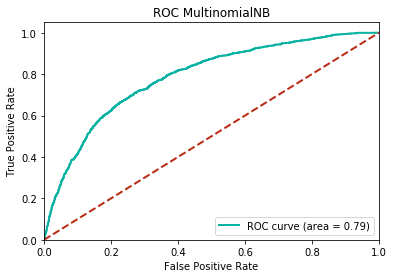

In [10]:
NB1 = MultinomialNB()
NB1.fit(train_X_tf_cm, train_y)
model_predict(NB1,train_X_tf_cm,test_X_tf_cm,train_y,test_y)

#### RF

Accuracy
Train Accuracy : 0.9758748485496401
Test Accuracy  : 0.7745664739884393

Confusion Matrix
True Negative: 4230
True Positive: 594
False Negative: 987
False Positive: 417

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.81      0.91      0.86      4647
    Superhost       0.59      0.38      0.46      1581

     accuracy                           0.77      6228
    macro avg       0.70      0.64      0.66      6228
 weighted avg       0.75      0.77      0.76      6228




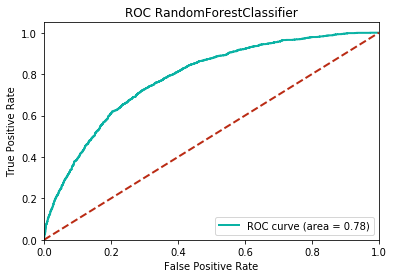

In [11]:
RF1 = RandomForestClassifier(max_depth = 70,n_estimators=1000,n_jobs=-1)
RF1.fit(train_X_tf_cm, train_y)
model_predict(RF1,train_X_tf_cm,test_X_tf_cm,train_y,test_y)

#### xgb

c:\users\xiao\anaconda3\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy
Train Accuracy : 0.9996080108331552
Test Accuracy  : 0.7965639049454079

Confusion Matrix
True Negative: 4212
True Positive: 749
False Negative: 832
False Positive: 435

Classification Report
               precision    recall  f1-score   support

Not_Superhost       0.84      0.91      0.87      4647
    Superhost       0.63      0.47      0.54      1581

     accuracy                           0.80      6228
    macro avg       0.73      0.69      0.71      6228
 weighted avg       0.78      0.80      0.79      6228




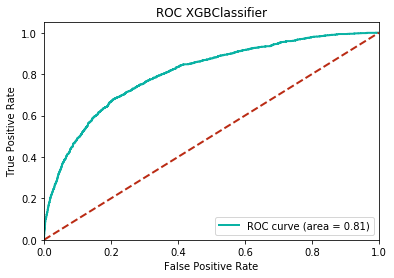

In [12]:
xgb1 = XGBClassifier(learning_rate = 0.2,max_depth=10,n_estimators=1000)
xgb1.fit(train_X_tf_cm, train_y)
model_predict(xgb1,train_X_tf_cm,test_X_tf_cm,train_y,test_y)

### Combine?

In [14]:
# train_X_tf.drop(['comments'],axis=1,inplace=True)
# test_X_tf.drop(['comments'],axis=1,inplace=True)

In [25]:
train_X_tf_cm.toarray()

MemoryError: Unable to allocate 91.2 GiB for an array with shape (28062, 436093) and data type float64

In [ ]:
## Consider using dataframemapper

In [ ]:
# LR2 = make_pipeline(SimpleImputer(), StandardScaler(),LogisticRegression(max_iter=1000))
# LR2.fit(train_X_tf, train_y)
# model_predict(LR2,train_X_tf,test_X_tf,train_y,test_y)